# Demo: *M*<sub>c</sub><sup>Lilliefors</sup> method

Associated publication:
> Herrmann, M. and W. Marzocchi (2021). Inconsistencies and Lurking Pitfalls in the Magnitude–Frequency Distribution of High-Resolution Earthquake Catalogs. *Seismological Research Letters 92*(2A). doi: [10.1785/0220200337](https://doi.org/10.1785/0220200337)

This notebook demonstrates how to obtain an estimate of the lowest magnitude cutoff, or completeness magnitude, *M*<sub>c</sub>, that complies with the exponential-like distribution of the Gutenberg–Richter relation.
Note that an exponential-like distribution above *M*<sub>c</sub> is a necessary and sufficient condition to calculate the *b*-value of the Gutenberg–Richter relation (otherwise the physical meaning of the *b*-value becomes questionable).
We use the [Lilliefors test](https://en.wikipedia.org/wiki/Lilliefors_test) [*Lilliefors* 1969], a statistical goodness-of-fit test with the exponential distribution, to determine the lowest magnitude cutoff above which the magnitude is exponentially distributed, which we call *M*<sub>c</sub><sup>Lilliefors</sup>. In other words, above *M*<sub>c</sub><sup>Lilliefors</sup>, the magnitude–frequency distribution is consistent with the exponential-like Gutenberg–Richter relation.

The basic principle of our method consists in calculating the Lilliefors [*p*-value](https://en.wikipedia.org/wiki/P-value) as a function of *M*<sub>c</sub> and determine the lowest magnitude level (*M*<sub>c</sub><sup>Lilliefors</sup>) above which the exponential distribution cannot be rejected.
A plot of those *p*-values helps to assess if *M*<sub>c</sub><sup>Lilliefors</sup> relates to only a short-lived exponentiality (i.e., non-persistent exponentiality with increasing *M*<sub>c</sub>), or a more robust signal of exponentiality (see below).

> Lilliefors, H. W. (1969). On the Kolmogorov-Smirnov Test for the Exponential Distribution with Mean Unknown. *Journal of the American Statistical Association, 64*(325), 387–389. doi: [10.2307/2283748](https://doi.org/10.2307/2283748) 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-necessary-packages-and-code" data-toc-modified-id="Import-necessary-packages-and-code-1">Import necessary packages and code</a></span></li><li><span><a href="#Load-an-earthquake-catalog" data-toc-modified-id="Load-an-earthquake-catalog-2">Load an earthquake catalog</a></span></li><li><span><a href="#Calculate-Lilliefors-p-values-as-function-of-Mc" data-toc-modified-id="Calculate-Lilliefors-p-values-as-function-of-Mc-3">Calculate Lilliefors <em>p</em>-values as function of <em>M</em><sub>c</sub></a></span></li><li><span><a href="#Plot-Lilliefors-p-value-distribution-as-function-of-Mc" data-toc-modified-id="Plot-Lilliefors-p-value-distribution-as-function-of-Mc-4">Plot Lilliefors <em>p</em>-value distribution as function of <em>M</em><sub>c</sub></a></span><ul class="toc-item"><li><span><a href="#with-plotly-(static)" data-toc-modified-id="with-plotly-(static)-4.1">with plotly (static)</a></span></li><li><span><a href="#with-plotly-(interactive)" data-toc-modified-id="with-plotly-(interactive)-4.2">with plotly (interactive)</a></span></li></ul></li><li><span><a href="#Determine-McLilliefors" data-toc-modified-id="Determine-McLilliefors-5">Determine <em>M</em><sub>c</sub><sup>Lilliefors</sup></a></span></li></ul></div>

### Import necessary packages and code

Note: the *McLilliefors* class depends on these packages:

    numpy, statsmodels, tqdm, plotly
    
So please make sure that they are installed. (<tt>plotly</tt> is only used for plotting and may be omitted).

In [1]:
import sys
import logging
import pandas as pd
import plotly.io as pio

from mc_lilliefors import McLilliefors  # custom class

# -- Setup plotly

# Default plot type
# pio.renderers.default = 'plotly_mimetype+notebook'  # interactive
# pio.renderers.default = 'plotly_mimetype+notebook_connected'  # interactive with internet connection
pio.renderers.default = 'png'  # static

# Set plotly template
# pio.templates.default = 'plotly'  # [default]
pio.templates.default = 'simple_white'  # publication-friendly

# -- Setup logger
logger = logging.getLogger()
c_handler = logging.StreamHandler(sys.stdout)  # avoid red colored cells by not logging to stderr
logger.setLevel(logging.INFO)
c_handler.setFormatter(logging.Formatter('%(message)s'))
logger.handlers = [c_handler]

### Load an earthquake catalog

As example, using this catalog of the 2019 Ridgecrest sequence:

> Shelly, D. R. (2020). A High-Resolution Seismic Catalog for the Initial 2019 Ridgecrest Earthquake Sequence: Foreshocks, Aftershocks, and Faulting Complexity. *Seismological Research Letters, 91*(4), 1971–1978. doi: [10.1785/0220190309](https://doi.org/10.1785/0220190309)

<!-- https://pubs.geoscienceworld.org/ssa/srl/article/580481/A-HighResolution-Seismic-Catalog-for-the-Initial -->

Download data release from: [USGS ScienceBase](https://www.sciencebase.gov/catalog/item/5dd715f3e4b0695797650d18)
(doi: [10.5066/P9JN6H0N](https://doi.org/10.5066/P9JN6H0N))

In [2]:
URL = "https://www.sciencebase.gov/catalog/file/get/5dd715f3e4b0695797650d18?" \
      + "f=__disk__db%2F88%2Fa1%2Fdb88a1f6754843800f25bd63712ed438dfa7699f&allowOpen=true"
columns = ('Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Lat', 'Lon', 'Depth', 'Mag', 'ID')

kw_pandas = dict(sep=r'\s+', skiprows=25, names=columns)

# For pandas v0.19.2+ [https://stackoverflow.com/a/32400969]
df = pd.read_csv(URL, **kw_pandas)  # pass URL directly

# For older pandas versions (request content separately)
# import io, requests
# df = pd.read_csv(io.StringIO(requests.get(URL).content.decode('utf-8')), kw_pandas)

### Calculate Lilliefors *p*-values as function of *M*<sub>c</sub>

Because the exponential distribution is a continuous probability distribution, the discretized magnitudes (here: in 0.01 bins) are transformed into a continuous random variable by adding uniformly sampled random noise $\mathcal{U}(-\frac{\Delta M}{2}, \frac{\Delta M}{2})$, i.e., within the binning interval $\Delta M$.
To avoid fluctuations, we perform the calculation for a total of 50 initializations of the random noise (you can change this value) to obtain a distribution of *p*-vaues for each possible *M*<sub>c</sub>.

In [3]:
# Reload class (e.g., to consider modifications in the code)
import importlib
import mc_lilliefors
importlib.reload(mc_lilliefors)
from mc_lilliefors import McLilliefors

lill = McLilliefors(
    df.Mag,
    # signif_lev=0.1  # [default: 0.1]
)

lill.calc_testdistr_mcutoff(
    n_repeats=50,  # number of iterations for the random noise
    Mstart=1.0,  # lowest magnitude for which to perform the test
    # log=False,  # whether to show anythe progress bar
)



Detected magnitude binning: 0.01
Getting test distributions (50x) for 611 magnitude cutoffs...
100%|████████████████████████████████████████████████████████████████| 611/611 [00:37<00:00, 16.19it/s]


### Plot Lilliefors *p*-value distribution as function of *M*<sub>c</sub>

#### with plotly (static)

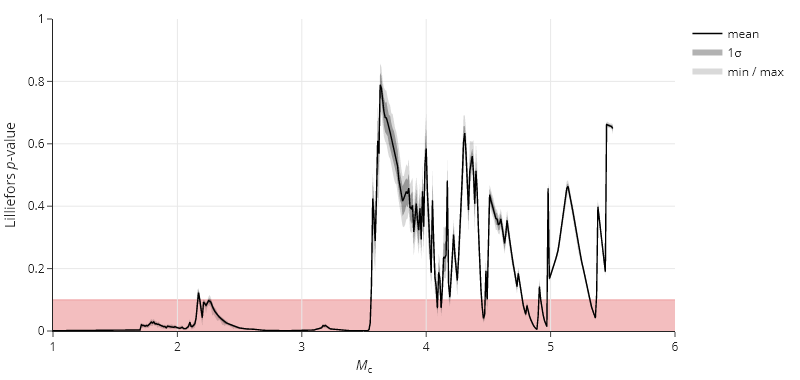

In [4]:
fig = lill.plot_testdist_expon_mcutoff()
fig.layout.update(
    xaxis_range=(1, 6.0),
)

fig.show(width=fig.layout.width, height=fig.layout.height)

(same as the dark green curve in Fig. 1f of *Herrmann and Marzocchi* 2020)

#### with plotly (interactive)

In [5]:
fig = lill.plot_testdist_expon_mcutoff()
fig.layout.update(
    xaxis_range=(1, 6.0),
)

fig.show(renderer='notebook_connected', width=fig.layout.width, height=fig.layout.height)

### Determine *M*<sub>c</sub><sup>Lilliefors</sup>

The calculated *p*-value is now used to estimate the "Lilliefors-test-based" magnitude of completeness, *M*<sub>c</sub><sup>Lilliefors</sup>. It is determined as the lowest magnitude where the average *p*-value (among the random noise initializations) is above the significance level (here: $\alpha$ = 0.1). For robustness, this average *p*-value must exceed the significance level for at least 0.05 magnitude units, in which case the first exceedance, i.e., the smallest magnitude bin, yields the eventual *M*<sub>c</sub><sup>Lilliefors</sup>.

In [8]:
Mc = lill.estimate_Mc_expon_test()

print("Mc-Lilliefors: %s\n   --> number of events ≥ Mc-Lilliefors: %d" % (Mc, lill.estimates['n_compl']))

Mc-Lilliefors: 3.56
   --> number of events ≥ Mc-Lilliefors: 178


Note that the *p*-value peaks above $\alpha$ (i.e. into the non-rejection range) at around *M*2.2, but it is not a robust/strong signal, so that the next exceedance at *M*3.56 determines *M*<sub>c</sub><sup>Lilliefors</sup>.

Even if the *p*-value around *M*2.2 were exceeding $\alpha$ more strongly, it would only relate to a short-lived exponentiality (i.e., not persistent with *M*<sub>c</sub>) of the smaller events and not to the exponential distribution of the largest events.

<br>

Check out our paper for more information, applications, and findings.

<br>

If you are interested in a subsequent <i>b</i>-value estimation, have a look at the [`FMD` class here](https://gitlab.seismo.ethz.ch/microEQ/TM/blob/master/TM/analysis.py#L910), which supports this. Since the `McLilliefors` class is related to it, both are compatible and could be merged (then, only `FMD._calc_Mc()` needs to be modified to support the 'Lilliefors' method).

<br><br><br>

---

Copyright © 2020 Marcus Herrmann · Warner Marzocchi — Università degli Studi di Napoli 'Federico II'

Licensed under the [European Union Public Licence](https://joinup.ec.europa.eu/collection/eupl) ([EUPL-1.2-or-later](https://joinup.ec.europa.eu/collection/eupl/eupl-text-eupl-12))